In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
data = pd.read_csv("winequality-red.csv", sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
for i in range(len(data)):
    if data.iloc[i,-2] > 5:
        data.iloc[i,-1] = 1

In [3]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size= 0.2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# train and test dataloaders
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)

In [8]:
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        # hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)


        # output layer
        self.output = nn.Linear(32,1)

        self.actfun = actfun

    def forward(self, x):
        actfun = getattr(torch, self.actfun)
        x = actfun(self.input(x))
        x = actfun(self.fc1(x))
        x = actfun(self.fc2(x))
        return self.output(x)        

In [11]:
net = ANNwine('sigmoid')
net(torch.randn(10,11)).shape

torch.Size([10, 1])

In [36]:
numepochs = 1000

def trainTheModel():
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr = .01)

    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):
        winenet.train()
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            
            yHat = winenet(X)
            loss = lossfun(yHat, y)

            # back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        trainAcc.append(np.mean(batchAcc))


        losses[epochi] = np.mean(batchLoss)

        winenet.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat > 0)==y).float()).item())

    return trainAcc, testAcc, losses



In [37]:
# listing activation function to test
activation_funs = ['relu', 'tanh', 'sigmoid']

trainByAct = np.zeros((numepochs, len(activation_funs)))
testByAct = np.zeros((numepochs, len(activation_funs)))

for ai, actfun in enumerate(activation_funs):

    winenet = ANNwine(actfun)
    trainByAct[:,ai],testByAct[:,ai], losses = trainTheModel()

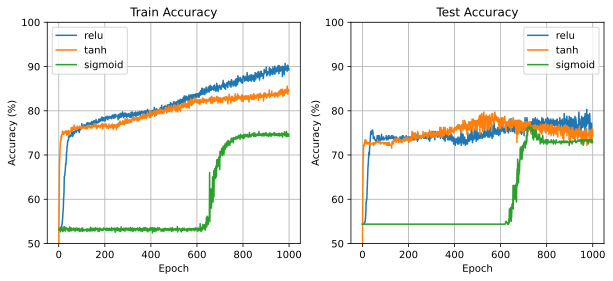

In [38]:
fig, ax = plt.subplots(1,2,figsize = (10,4))

ax[0].plot(trainByAct)
ax[0].set_title('Train Accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test Accuracy')


for i in range(2):
    ax[i].legend(activation_funs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,100])
    ax[i].grid()
plt.show()
